# Imports

In [129]:
from os import walk
from os.path import join
import pandas as pd

import matplotlib.pyplot as plt

import nltk
from nltk.stem import PorterStemmer, SnowballStemmer
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

from bs4 import BeautifulSoup

import numpy as np
from sklearn.model_selection import train_test_split

%matplotlib inline

# Generator Functions

In [154]:
spam_1_path = 'SpamData/01_Processing/spam_assassin_corpus/spam_1'
spam_2_path = 'SpamData/01_Processing/spam_assassin_corpus/spam_2'
easy_ham_1 = 'SpamData/01_Processing/spam_assassin_corpus/easy_ham_1'
easy_ham_2 = 'SpamData/01_Processing/spam_assassin_corpus/easy_ham_2'

spam_cat = 1
ham_cat = 0

vocab_size = 2500

mail_json_file = 'SpamData/01_Processing/email-text-data.json'
word_id_json_file = 'SpamData/01_Processing/word-by-id.csv.json'
training_data_file = 'SpamData/02_Training/training_data.txt'
test_data_file = 'SpamData/02_Training/test_data.txt'

In [3]:
def email_body_extractor(path):
    for root, dir_names, file_names in walk(path):
        for file_name in file_names:
            file_path = join(root, file_name)
            is_body = False
            email_body = []
            with open(file_path, encoding='latin-1') as mail:
                for line in mail:
                    if is_body:
                        email_body.append(line)
                    elif line == '\n':
                        is_body = True
            yield file_name, '\n'.join(email_body)

In [4]:
def df_from_dir(path, classification):
    rows = []
    row_names = []
    for file_name, email_body in email_body_extractor(path):
        rows.append({'category': classification, 'message': email_body})
        row_names.append(file_name)
    return pd.DataFrame(rows, index=row_names)

In [5]:
spam_emails = df_from_dir(spam_1_path, spam_cat)
spam_emails = pd.concat([spam_emails, df_from_dir(spam_2_path, 1)])
spam_emails

,category,message
00001.7848dde101aa985090474a91ec93fcf0,1,"<!DOCTYPE HTML PUBLIC ""-//W3C//DTD HTML 4.0 Tr..."
00002.d94f1b97e48ed3b553b3508d116e6a09,1,1) Fight The Risk of Cancer!\n\nhttp://www.adc...
00003.2ee33bc6eacdb11f38d052c44819ba6c,1,1) Fight The Risk of Cancer!\n\nhttp://www.adc...
00004.eac8de8d759b7e74154f142194282724,1,##############################################...
00005.57696a39d7d84318ce497886896bf90d,1,I thought you might like these:\n\n1) Slim Dow...
...,...,...
01397.f75f0dd0dd923faefa3e9cc5ecb8c906,1,This is a multi-part message in MIME format.\n...
01398.8ca7045aae4184d56e8509dc5ad6d979,1,"Dear Subscriber,\n\n\n\nIf I could show you a ..."
01399.2319643317e2c5193d574e40a71809c2,1,****Mid-Summer Customer Appreciation SALE!****...
01400.b444b69845db2fa0a4693ca04e6ac5c5,1,ATTN:SIR/MADAN \n\n\n\n ...


In [6]:
ham_mails = df_from_dir(easy_ham_1, ham_cat)
ham_mails = pd.concat([ham_mails, df_from_dir(easy_ham_2, ham_cat)])
ham_mails

,category,message
00001.7c53336b37003a9286aba55d2945844c,0,"Date: Wed, 21 Aug 2002 10:54:46 -05..."
00002.9c4069e25e1ef370c078db7ee85ff9ac,0,"Martin A posted:\n\nTassos Papadopoulos, the G..."
00003.860e3c3cee1b42ead714c5c874fe25f7,0,Man Threatens Explosion In Moscow \n\n\n\nThur...
00004.864220c5b6930b209cc287c361c99af1,0,Klez: The Virus That Won't Die\n\n \n\nAlready...
00005.bf27cdeaf0b8c4647ecd61b1d09da613,0,"> in adding cream to spaghetti carbonara, whi..."
...,...,...
01396.61983fbe6ec43f55fd44e30fce24ffa6,0,http://news.bbc.co.uk/1/hi/england/2515127.stm...
01397.9f9ef4c2a8dc012d80f2ce2d3473d3b7,0,"> >-- be careful when using this one.) Also, t..."
01398.169b51731fe569f42169ae8f948ec676,0,">>>>> ""SM"" == Skip Montanaro <skip@pobox.com> ..."
01399.ca6b00b7b341bbde9a9ea3dd6a7bf896,0,"So then, ""Mark Hammond"" <mhammond@skippinet.co..."


In [7]:
mail_df = pd.concat([spam_emails, ham_mails])
mail_df

,category,message
00001.7848dde101aa985090474a91ec93fcf0,1,"<!DOCTYPE HTML PUBLIC ""-//W3C//DTD HTML 4.0 Tr..."
00002.d94f1b97e48ed3b553b3508d116e6a09,1,1) Fight The Risk of Cancer!\n\nhttp://www.adc...
00003.2ee33bc6eacdb11f38d052c44819ba6c,1,1) Fight The Risk of Cancer!\n\nhttp://www.adc...
00004.eac8de8d759b7e74154f142194282724,1,##############################################...
00005.57696a39d7d84318ce497886896bf90d,1,I thought you might like these:\n\n1) Slim Dow...
...,...,...
01396.61983fbe6ec43f55fd44e30fce24ffa6,0,http://news.bbc.co.uk/1/hi/england/2515127.stm...
01397.9f9ef4c2a8dc012d80f2ce2d3473d3b7,0,"> >-- be careful when using this one.) Also, t..."
01398.169b51731fe569f42169ae8f948ec676,0,">>>>> ""SM"" == Skip Montanaro <skip@pobox.com> ..."
01399.ca6b00b7b341bbde9a9ea3dd6a7bf896,0,"So then, ""Mark Hammond"" <mhammond@skippinet.co..."


# Cleaning Data: Checking for Missing values

In [8]:
mail_df.message.isnull().any()

False

In [9]:
(mail_df.message.str.len() == 0).sum()

3

In [10]:
mail_df[mail_df.message.str.len() == 0]

,category,message
cmds,1,
cmds,1,
cmds,0,


# Locate Empty Emails and remove tham

In [11]:
mail_df = mail_df[mail_df.message.str.len() != 0]

# Add Document ids to track Emails in Dataset

In [12]:
document_id = range(0, len(mail_df.message))
mail_df['doc_id'] = document_id

C:\Users\Administrator\AppData\Local\Temp\ipykernel_9192\342004327.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mail_df['doc_id'] = document_id


In [13]:
mail_df['file_name'] = mail_df.index

C:\Users\Administrator\AppData\Local\Temp\ipykernel_9192\4141420947.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mail_df['file_name'] = mail_df.index


In [14]:
mail_df

,category,message,doc_id,file_name
00001.7848dde101aa985090474a91ec93fcf0,1,"<!DOCTYPE HTML PUBLIC ""-//W3C//DTD HTML 4.0 Tr...",0,00001.7848dde101aa985090474a91ec93fcf0
00002.d94f1b97e48ed3b553b3508d116e6a09,1,1) Fight The Risk of Cancer!\n\nhttp://www.adc...,1,00002.d94f1b97e48ed3b553b3508d116e6a09
00003.2ee33bc6eacdb11f38d052c44819ba6c,1,1) Fight The Risk of Cancer!\n\nhttp://www.adc...,2,00003.2ee33bc6eacdb11f38d052c44819ba6c
00004.eac8de8d759b7e74154f142194282724,1,##############################################...,3,00004.eac8de8d759b7e74154f142194282724
00005.57696a39d7d84318ce497886896bf90d,1,I thought you might like these:\n\n1) Slim Dow...,4,00005.57696a39d7d84318ce497886896bf90d
...,...,...,...,...
01396.61983fbe6ec43f55fd44e30fce24ffa6,0,http://news.bbc.co.uk/1/hi/england/2515127.stm...,5791,01396.61983fbe6ec43f55fd44e30fce24ffa6
01397.9f9ef4c2a8dc012d80f2ce2d3473d3b7,0,"> >-- be careful when using this one.) Also, t...",5792,01397.9f9ef4c2a8dc012d80f2ce2d3473d3b7
01398.169b51731fe569f42169ae8f948ec676,0,">>>>> ""SM"" == Skip Montanaro <skip@pobox.com> ...",5793,01398.169b51731fe569f42169ae8f948ec676
01399.ca6b00b7b341bbde9a9ea3dd6a7bf896,0,"So then, ""Mark Hammond"" <mhammond@skippinet.co...",5794,01399.ca6b00b7b341bbde9a9ea3dd6a7bf896


In [15]:
mail_df.set_index('doc_id', inplace=True)
mail_df.head()

,category,message,file_name
doc_id,,,
0,1,"<!DOCTYPE HTML PUBLIC ""-//W3C//DTD HTML 4.0 Tr...",00001.7848dde101aa985090474a91ec93fcf0
1,1,1) Fight The Risk of Cancer!\n\nhttp://www.adc...,00002.d94f1b97e48ed3b553b3508d116e6a09
2,1,1) Fight The Risk of Cancer!\n\nhttp://www.adc...,00003.2ee33bc6eacdb11f38d052c44819ba6c
3,1,##############################################...,00004.eac8de8d759b7e74154f142194282724
4,1,I thought you might like these:\n\n1) Slim Dow...,00005.57696a39d7d84318ce497886896bf90d


In [16]:
mail_df.tail()

,category,message,file_name
doc_id,,,
5791,0,http://news.bbc.co.uk/1/hi/england/2515127.stm...,01396.61983fbe6ec43f55fd44e30fce24ffa6
5792,0,"> >-- be careful when using this one.) Also, t...",01397.9f9ef4c2a8dc012d80f2ce2d3473d3b7
5793,0,">>>>> ""SM"" == Skip Montanaro <skip@pobox.com> ...",01398.169b51731fe569f42169ae8f948ec676
5794,0,"So then, ""Mark Hammond"" <mhammond@skippinet.co...",01399.ca6b00b7b341bbde9a9ea3dd6a7bf896
5795,0,"Hi there,\n\n\n\nNow this is probably of no us...",01400.f897f0931e461e7b2e964d28e927c35e


# Save to File using Pandas

In [17]:
mail_df.to_json(mail_json_file)

# Number of Spam messages Visualised (Pie Chart)

In [18]:
mail_df.category.value_counts()

0    3900
1    1896
Name: category, dtype: int64

In [19]:
amount_of_spam = mail_df.category.value_counts()[1]
amount_of_ham = mail_df.category.value_counts()[0]

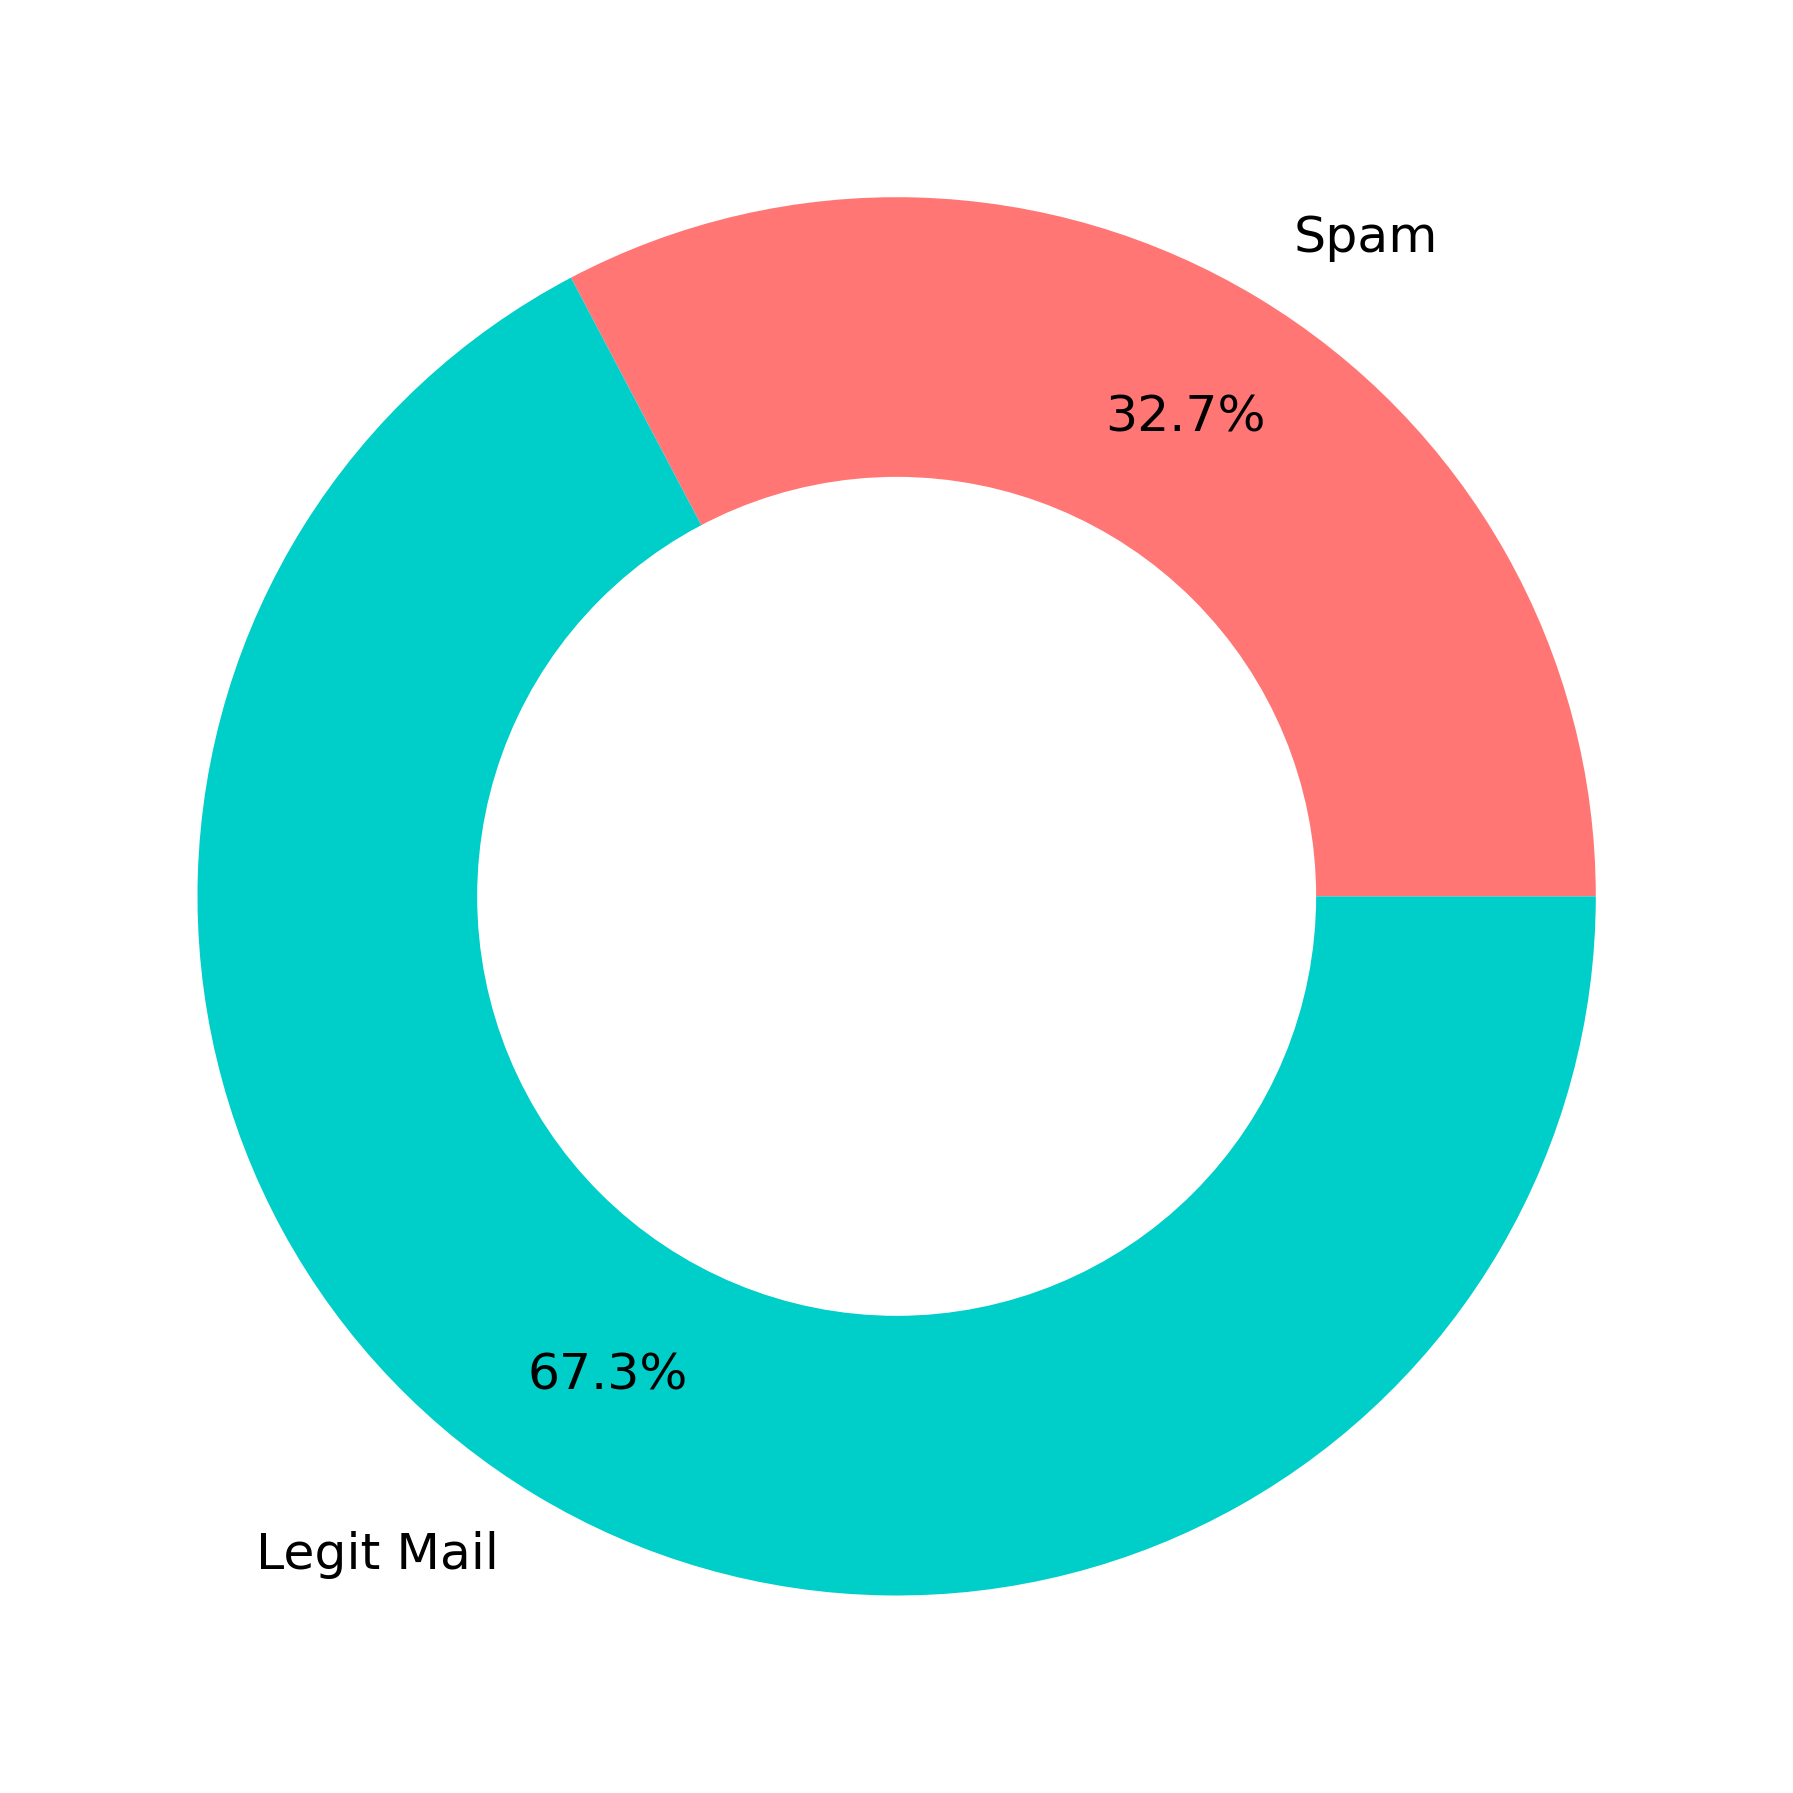

In [20]:
category = ['Spam', 'Legit Mail']
sizes = [amount_of_spam, amount_of_ham]
coustom_colours = ['#ff7675', '#00cec9']
plt.figure(figsize=(16, 10), dpi=227)
plt.pie(sizes, labels=category, textprops={'fontsize':16}, startangle=0, autopct='%1.1f%%', colors=coustom_colours, pctdistance=0.8)

centre_scircle = plt.Circle((0, 0), radius=0.6, fc='white')
plt.gca().add_artist(centre_scircle)

plt.show()

# Natural language Processing

## Text pre_processing


In [21]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Administrator\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [22]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Administrator\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [23]:
nltk.download('gutenberg')
nltk.download('shakespeare')

[nltk_data] Downloading package gutenberg to
[nltk_data]     C:\Users\Administrator\AppData\Roaming\nltk_data...
[nltk_data]   Package gutenberg is already up-to-date!
[nltk_data] Downloading package shakespeare to
[nltk_data]     C:\Users\Administrator\AppData\Roaming\nltk_data...
[nltk_data]   Package shakespeare is already up-to-date!


True

In [24]:
msg = 'All work and no play makes Jack a dull boy.'
word_tokenize(msg.lower())

['all', 'work', 'and', 'no', 'play', 'makes', 'jack', 'a', 'dull', 'boy', '.']

In [25]:
stop_words = set(stopwords.words('english'))

In [26]:
msg = 'All work and no play makes Jack a dull boy. To be or not to be.'
words = word_tokenize(msg.lower())

# stemmer = PorterStemmer()
stemmer = SnowballStemmer('english')


filtered_words = []
for word in words:
    if word not in stop_words:
        stemmed_word = stemmer.stem(word)
        filtered_words.append(stemmed_word)

print(filtered_words)

['work', 'play', 'make', 'jack', 'dull', 'boy', '.', '.']


# Removing Punctuation

In [27]:
msg = 'All work and no play makes Jack a dull boy. To be or not to be.'
words = word_tokenize(msg.lower())

# stemmer = PorterStemmer()
stemmer = SnowballStemmer('english')


filtered_words = []
for word in words:
    if word not in stop_words and word.isalpha():
        stemmed_word = stemmer.stem(word)
        filtered_words.append(stemmed_word)

print(filtered_words)

['work', 'play', 'make', 'jack', 'dull', 'boy']


# Functions for email processing

In [28]:
def clean_message(message, stemmer=PorterStemmer(),
                  stop_words=None):
    if stop_words is None:
        stop_words = set(stopwords.words('english'))
    soup = BeautifulSoup(message, 'html.parser')
    words = word_tokenize(soup.get_text().lower())

    fitted_words = []

    for word in words:
        if word not in stop_words and word.isalpha():
            fitted_words.append(stemmer.stem(word))
    return fitted_words

In [29]:
print(clean_message(mail_df[mail_df.index == 2].message.item()))

['fight', 'risk', 'cancer', 'http', 'slim', 'guarante', 'lose', 'lb', 'day', 'http', 'get', 'child', 'support', 'deserv', 'free', 'legal', 'advic', 'http', 'join', 'web', 'fastest', 'grow', 'singl', 'commun', 'http', 'start', 'privat', 'photo', 'album', 'onlin', 'http', 'wonder', 'day', 'offer', 'manag', 'prizemama', 'wish', 'leav', 'list', 'pleas', 'use', 'link', 'http', 'zzzz']


# Apply Cleaning and Tokenisation to all messages

In [30]:
mail_df.iat[2, 2]

'00003.2ee33bc6eacdb11f38d052c44819ba6c'

In [31]:
mail_df.iloc[5:11]

,category,message,file_name
doc_id,,,
5,1,A POWERHOUSE GIFTING PROGRAM You Don't Want To...,00006.5ab5620d3d7c6c0db76234556a16f6c1
6,1,Help wanted. We are a 14 year old fortune 500...,00007.d8521faf753ff9ee989122f6816f87d7
7,1,<html>\n\n<head>\n\n<title>ReliaQuote - Save U...,00008.dfd941deb10f5eed78b1594b131c9266
8,1,TIRED OF THE BULL OUT THERE?\n\nWant To Stop L...,00009.027bf6e0b0c4ab34db3ce0ea4bf2edab
9,1,"Dear ricardo1 ,\n\n\n\n<html>\n\n<body>\n\n<ce...",00010.445affef4c70feec58f9198cfbc22997
10,1,Cellular Phone Accessories All At Below Wholes...,00011.61816b9ad167657773a427d890d0468e


In [32]:
first_mail = mail_df.iloc[0:3]
nested_list = first_mail.message.apply(clean_message)

In [33]:
flat_lst = []
for sublist in  nested_list:
    for item in sublist:
        flat_lst.append(item)
flat_lst

['save',
 'life',
 'insur',
 'spend',
 'life',
 'quot',
 'save',
 'g',
 'famili',
 'financi',
 'secur',
 'import',
 'life',
 'quot',
 'save',
 'ke',
 'buy',
 'life',
 'insur',
 'simpl',
 'afford',
 'provid',
 'free',
 'access',
 'best',
 'compani',
 'lowest',
 'rate',
 'life',
 'quot',
 'save',
 'fast',
 'save',
 'money',
 'let',
 'us',
 'help',
 'get',
 'start',
 'best',
 'ue',
 'countri',
 'new',
 'coverag',
 'save',
 'hundr',
 'even',
 'usand',
 'dollar',
 'request',
 'free',
 'quot',
 'lifequot',
 'save',
 'servic',
 'take',
 'less',
 'minut',
 'complet',
 'shop',
 'compar',
 'save',
 'type',
 'life',
 'insur',
 'click',
 'free',
 'quot',
 'protect',
 'famili',
 'best',
 'invest',
 'r',
 'make',
 'receipt',
 'email',
 'error',
 'wish',
 'remov',
 'list',
 'pleas',
 'click',
 'type',
 'remov',
 'resid',
 'state',
 'prohibit',
 'solicit',
 'ce',
 'pleas',
 'disregard',
 'email',
 'fight',
 'risk',
 'cancer',
 'http',
 'slim',
 'guarante',
 'lose',
 'lb',
 'day',
 'http',
 'get',
 'ch

In [34]:
flat_lst = [item for sublist in nested_list for item in sublist]
flat_lst

['save',
 'life',
 'insur',
 'spend',
 'life',
 'quot',
 'save',
 'g',
 'famili',
 'financi',
 'secur',
 'import',
 'life',
 'quot',
 'save',
 'ke',
 'buy',
 'life',
 'insur',
 'simpl',
 'afford',
 'provid',
 'free',
 'access',
 'best',
 'compani',
 'lowest',
 'rate',
 'life',
 'quot',
 'save',
 'fast',
 'save',
 'money',
 'let',
 'us',
 'help',
 'get',
 'start',
 'best',
 'ue',
 'countri',
 'new',
 'coverag',
 'save',
 'hundr',
 'even',
 'usand',
 'dollar',
 'request',
 'free',
 'quot',
 'lifequot',
 'save',
 'servic',
 'take',
 'less',
 'minut',
 'complet',
 'shop',
 'compar',
 'save',
 'type',
 'life',
 'insur',
 'click',
 'free',
 'quot',
 'protect',
 'famili',
 'best',
 'invest',
 'r',
 'make',
 'receipt',
 'email',
 'error',
 'wish',
 'remov',
 'list',
 'pleas',
 'click',
 'type',
 'remov',
 'resid',
 'state',
 'prohibit',
 'solicit',
 'ce',
 'pleas',
 'disregard',
 'email',
 'fight',
 'risk',
 'cancer',
 'http',
 'slim',
 'guarante',
 'lose',
 'lb',
 'day',
 'http',
 'get',
 'ch

In [35]:
%%time

nested_list = mail_df.message.apply(clean_message)

C:\Program Files\Python311\Lib\site-packages\bs4\__init__.py:435: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  warnings.warn(
C:\Program Files\Python311\Lib\site-packages\bs4\__init__.py:404: MarkupResemblesLocatorWarning: The input looks more like a URL than markup. You may want to use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  warnings.warn(


CPU times: total: 7.31 s
Wall time: 41.2 s


In [36]:
nested_list.tail()

doc_id
5791    [http, bizarr, collect, stuf, anim, could, fet...
5792    [care, use, one, also, realli, cute, thing, ja...
5793    [sm, skip, montanaro, write, jeremi, put, anot...
5794    [mark, hammond, like, given, zodb, sound, attr...
5795    [hi, probabl, use, whatsoev, also, problem, re...
Name: message, dtype: object

## Using Logic to Slice Dataframes

In [41]:
spam_slice = mail_df[mail_df.category == 1].index
ham_slice = mail_df[mail_df.category == 0].index
ham_slice

Int64Index([1896, 1897, 1898, 1899, 1900, 1901, 1902, 1903, 1904, 1905,
            ...
            5786, 5787, 5788, 5789, 5790, 5791, 5792, 5793, 5794, 5795],
           dtype='int64', name='doc_id', length=3900)

### Subsetting series with an index

In [43]:
nested_list_spam = nested_list.loc[spam_slice]
nested_list_ham = nested_list.loc[ham_slice]

In [53]:
all_words_spam = [sublist for list in nested_list_spam for sublist in list]
all_words_ham = [sublist for list in nested_list_ham for sublist in list]
print('Spam word count:', len(all_words_spam),'\nHam word count:', len(all_words_ham))

Spam word count: 317502 
Ham word count: 442056


In [66]:
print('10 most common words in spam:\n',
      pd.DataFrame(all_words_spam).value_counts().head(10))
print('10 most common words in ham:\n',
      pd.DataFrame(all_words_ham).value_counts().head(10))

10 most common words in spam:
 http      3097
email     3090
free      2585
click     2058
receiv    1989
list      1971
get       1914
pleas     1852
busi      1792
order     1746
dtype: int64
10 most common words in ham:
 http      7563
use       3633
list      2880
one       2373
get       2286
mail      2255
would     2003
like      1931
messag    1849
work      1800
dtype: int64


# Generate Vocabulary and Dictionary

In [69]:
flat_all_list = [item for sublist in nested_list for item in sublist]
pd.Series(flat_all_list).value_counts().head()

http     10660
use       5019
list      4851
email     4367
get       4200
dtype: int64

In [73]:
frequent_words =  pd.Series(flat_all_list).value_counts().head(vocab_size)
frequent_words.head(10)

http     10660
use       5019
list      4851
email     4367
get       4200
mail      3983
one       3907
free      3202
time      3042
work      2883
dtype: int64

## Create Vocabulary DataFrame with a WORD_ID

In [78]:
word_id = list(range(0, vocab_size))

vocab = pd.DataFrame({'vocab_word': frequent_words.index.values}, index=word_id)

In [79]:
vocab

,vocab_word
0,http
1,use
2,list
3,email
4,get
...,...
2495,bob
2496,occasion
2497,bullet
2498,steven


## save the vocabulary as a CSV file

In [82]:
vocab.to_csv(word_id_json_file, index=vocab.index.name, header='vocab_word')

In [84]:
wrd_list = ['fun', 'science', 'sport', 'machine', 'computer', 'clear']

for word in wrd_list:
    print(word ,word in set(vocab.vocab_word.values))

fun True
science False
sport True
machine False
computer False
clear True


# Email with most number of words

In [98]:
df = pd.DataFrame(nested_list)

In [124]:
print(f'Number of words in the longest email: {len(df[df.message.str.len() == nested_list.str.len().max()].message.to_list()[0])}\n at index: {df[df.message.str.len() == nested_list.str.len().max()].index[0]}')

Number of words in the longest email: 7671
 at index: 5775


# Generate Functions & and Sparse Matrix

## Creating Dataframe with one work per column

In [125]:
word_columns_df = pd.DataFrame.from_records(nested_list.tolist())

In [127]:
word_columns_df.head()

,0,1,2,3,4,5,6,7,8,9,...,7661,7662,7663,7664,7665,7666,7667,7668,7669,7670
0,save,life,insur,spend,life,quot,save,g,famili,financi,...,None,None,None,None,None,None,None,None,None,None
1,fight,risk,cancer,http,slim,guarante,lose,lb,day,http,...,None,None,None,None,None,None,None,None,None,None
2,fight,risk,cancer,http,slim,guarante,lose,lb,day,http,...,None,None,None,None,None,None,None,None,None,None
3,adult,club,offer,free,membership,instant,access,site,user,name,...,None,None,None,None,None,None,None,None,None,None
4,thought,might,like,slim,guarante,lose,lb,day,http,fight,...,None,None,None,None,None,None,None,None,None,None


In [128]:
word_columns_df.shape

(5796, 7671)

### Splitting the Data into a Training and Testing Dataset

In [131]:

x_train, x_test, y_train, y_test = train_test_split(word_columns_df, mail_df.category, test_size=0.3, random_state=42)

In [134]:
print('Nr. of training samples', x_train.shape[0])
print('Fraction of Training set', x_train.shape[0]/word_columns_df.shape[0])

Nr. of training samples 4057
Fraction of Training set 0.6999654934437544


In [137]:
x_train.index.name = x_test.index.name = 'doc_id'
x_train.head()

,0,1,2,3,4,5,6,7,8,9,...,7661,7662,7663,7664,7665,7666,7667,7668,7669,7670
doc_id,,,,,,,,,,,,,,,,,,,,,
4844,ye,inde,agent,directori,verita,cd,unix,subdirectori,file,call,...,None,None,None,None,None,None,None,None,None,None
4727,problem,come,tri,instal,harddissssk,like,alreadi,mount,http,yahoo,...,None,None,None,None,None,None,None,None,None,None
5022,origin,messag,date,mon,aug,chad,norwood,sven,cc,subject,...,None,None,None,None,None,None,None,None,None,None
3504,inlin,folk,sever,major,internet,outag,morn,across,major,provid,...,None,None,None,None,None,None,None,None,None,None
3921,url,http,date,bath,chronicl,None,None,None,None,None,...,None,None,None,None,None,None,None,None,None,None


# create a sparce matrix

In [138]:
word_index = pd.Index(vocab.vocab_word)

In [140]:
def make_sparce_matrix(df, indexed_words, labels):
    nr_rows = df.shape[0]
    nr_cols = df.shape[1]
    word_set = set(indexed_words)
    dict_list = []
    for row in range(nr_rows):
        for column in range(nr_cols):
            word = x_train.iat[row, column]
            if word in word_set:
                doc_id = df.index[row]
                word_id = indexed_words.get_loc(word)
                category = labels.at[doc_id]

                item = {'label': category, 'doc_id': doc_id, 'occurence': 1, 'word_id':word_id}
                dict_list.append(item)
    return pd.DataFrame(dict_list)




In [141]:
%%time

sparce_train_df = make_sparce_matrix(x_train, word_index, y_train)


CPU times: total: 2min 6s
Wall time: 15min 6s


In [143]:
sparce_train_df[:5]

,label,doc_id,occurence,word_id
0,0,4844,1,265
1,0,4844,1,1243
2,0,4844,1,502
3,0,4844,1,308
4,0,4844,1,254


In [144]:
sparce_train_df.shape

(429241, 4)

### Combine occurrances with pandas groupby() method

In [145]:
train_grouped = sparce_train_df.groupby(['doc_id', 'word_id', 'label']).sum()

In [146]:
train_grouped

occurence
doc_id word_id label           
0      2       1              1
       3       1              2
       4       1              1
       7       1              3
       11      1              1
...                         ...
5795   2035    0              2
       2040    0              1
       2272    0              1
       2342    0              1
       2370    0              1

[258360 rows x 1 columns]

In [147]:
vocab.at[0, 'vocab_word']

'http'

In [149]:
train_grouped = train_grouped.reset_index()
train_grouped.head()

,index,doc_id,word_id,label,occurence
0,0,0,2,1,1
1,1,0,3,1,2
2,2,0,4,1,1
3,3,0,7,1,3
4,4,0,11,1,1


In [151]:
train_grouped.shape

(258360, 5)

### Save training data as .txt file

In [153]:
np.savetxt(training_data_file, train_grouped, fmt='%d')

In [156]:
sparce_test_df = make_sparce_matrix(x_test, word_index, y_test)

In [170]:
test_grouped = sparce_test_df.groupby(['doc_id', 'word_id', 'label']).sum()
test_grouped = test_grouped.reset_index()

In [171]:
test_grouped

,doc_id,word_id,label,occurence
0,8,0,1,1
1,8,2,1,1
2,8,9,1,1
3,8,13,1,1
4,8,15,1,1
...,...,...,...,...
107886,5793,1803,0,1
107887,5793,1959,0,1
107888,5793,2083,0,1
107889,5793,2388,0,2


In [168]:
np.savetxt(test_data_file, train_grouped, fmt='%d')

In [172]:
training_doc_ids = set(train_grouped.doc_id)
testing_doc_id = set(test_grouped.doc_id)

In [173]:
training_doc_ids

{0,
 1,
 2,
 3,
 4,
 5,
 6,
 7,
 9,
 10,
 11,
 13,
 16,
 18,
 20,
 21,
 24,
 25,
 27,
 28,
 31,
 32,
 34,
 35,
 36,
 39,
 40,
 41,
 42,
 46,
 48,
 49,
 50,
 52,
 53,
 54,
 55,
 56,
 57,
 58,
 59,
 60,
 64,
 66,
 67,
 72,
 74,
 76,
 78,
 81,
 82,
 83,
 85,
 87,
 89,
 92,
 97,
 98,
 103,
 104,
 105,
 108,
 111,
 112,
 113,
 115,
 116,
 117,
 118,
 119,
 123,
 125,
 126,
 128,
 129,
 130,
 131,
 133,
 136,
 137,
 140,
 141,
 143,
 145,
 146,
 147,
 148,
 152,
 153,
 154,
 155,
 158,
 159,
 160,
 161,
 162,
 163,
 164,
 165,
 166,
 169,
 170,
 171,
 172,
 173,
 174,
 176,
 178,
 180,
 182,
 187,
 188,
 189,
 190,
 191,
 194,
 198,
 200,
 201,
 202,
 204,
 207,
 209,
 211,
 212,
 213,
 215,
 216,
 220,
 222,
 223,
 224,
 225,
 226,
 231,
 232,
 234,
 235,
 236,
 237,
 241,
 242,
 243,
 244,
 246,
 249,
 250,
 253,
 255,
 256,
 258,
 260,
 261,
 262,
 264,
 265,
 266,
 267,
 268,
 269,
 270,
 271,
 273,
 275,
 276,
 277,
 278,
 280,
 281,
 282,
 284,
 285,
 288,
 289,
 294,
 299,
 301,
 303,